In [1]:
from PIL import Image
import os
import shutil
import numpy as np
# import cv2
import re
import pickle
import random
import time
# from tqdm import tqdm
import pandas as pd 
from glob import glob
from xml.etree.ElementTree import parse
# from pascal_voc_writer import Writer
import matplotlib.pyplot as plt

import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.auto import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.extend(['./detr/'])

from models.matcher import HungarianMatcher
from models.detr import SetCriterion
################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

import sys
sys.path.extend(['./util/'])
from data_parser import *
from image_prepro import *
# from torchvision import transforms

from visualize import *


In [2]:
df = pd.read_csv('df.csv')
df.drop(columns=['width', 'height'], inplace=True)

df['res'] = df.apply(lambda row : (row['h'], row['w']), axis=1)
df = df[['file_name', 'res', 'h', 'w', 'bbox', 'xmin', 'ymin', 'xmax', 'ymax', 'label', 'org_label', 'path']]
df.head()

,file_name,res,h,w,bbox,xmin,ymin,xmax,ymax,label,org_label,path
0,20200623_100015.jpg,"(4032, 1960)",4032,1960,"[2061, 1051, 2178, 1175]",2061,1051,2178,1175,Carcinoma,Suamous cell carcinoma,/home/beomgon/Object_Detection/Dataset/SS/06/2...
1,20200420_100401.jpg,"(4032, 1960)",4032,1960,"[1945, 870, 2024, 941]",1945,870,2024,941,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/06/2...
2,20200420_100401.jpg,"(4032, 1960)",4032,1960,"[2400, 947, 2484, 1020]",2400,947,2484,1020,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/06/2...
3,20200420_100401.jpg,"(4032, 1960)",4032,1960,"[2209, 845, 2307, 912]",2209,845,2307,912,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/06/2...
4,20200420_100401.jpg,"(4032, 1960)",4032,1960,"[2056, 811, 2144, 866]",2056,811,2144,866,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/06/2...


In [3]:
set(df['res'])

{(1560, 1632), (1800, 4000), (4000, 1800), (4032, 1960)}

In [4]:
# path = list(df1[df1['w'] == 1800]['path'])[1]
# path = list(df1[df1['w'] == 1960]['path'])[20]
# path = list(df1[df1['h'] == 4000]['path'])[10]
# path = list(df1[df1['h'] == 4032]['path'])[5]
# {1632, 1800, 1960, 4000} w
# {1560, 1800, 4000, 4032} h

In [5]:
# NUM=20000
# print(df[NUM:NUM+1])
# path = df.path[NUM]
# path = '/home/beomgon/Object_Detection/Dataset/SS/04/20200513_101513.png' #1560, 1632
# path = '/home/beomgon/Object_Detection/Dataset/SS2/07(201103)/20201103_143345.jpg' #1800, 4000
# path = '/home/beomgon/Object_Detection/Dataset/SS/06/20200623_100015.jpg'
# path = '/home/beomgon/Object_Detection/Dataset/SS2/03(200908-10-normal)/20200908_104214.jpg'

# path = list(df[df['h'] == 4032]['path'])[555]
# image = cv2.imread(path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# h, w, _ = image.shape
# if h == 1560 or h == 1800 :
#     pass
# else :
#     image = cv2.flip(image, 1)
# print(image.shape)
# my_df = df[df['path'] == path].copy()
# # print(my_df)
# my_df.reset_index(inplace=True)
# new_bboxes = []
# for i in range(len(my_df)) :
#     xmin, ymin, xmax, ymax = my_df.loc[i, 'xmin'], my_df.loc[i, 'ymin'], my_df.loc[i, 'xmax'], my_df.loc[i, 'ymax']
#     if h == 1560 or h == 1800 :
#         new_bboxes.append([xmin, ymin, xmax, ymax])
#     else :
#         new_bboxes.append([ymin, xmin, ymax, xmax])

# category_ids = [0] *len(new_bboxes)
# category_id_to_name = {0: 'Carcinoma', 1: 'normal'}
# visualize(image, new_bboxes, category_ids, category_id_to_name)

In [6]:
switched_df = (df[(df['h'] == 1800) | (df['h'] == 1560)]).copy()
not_switched_df = (df[(df['h'] != 1800) & (df['h'] != 1560)]).copy()
print(len(switched_df))
print(len(not_switched_df))
print(len(df))
switched_df.reset_index(drop=True, inplace=True)
not_switched_df.reset_index(drop=True, inplace=True)

12765
92619
105384


In [7]:
import operator

width = []
height = []
xmax_list = list(not_switched_df.xmax)
xmin_list = list(not_switched_df.xmin.apply(lambda x : -1*x))
ymax_list = list(not_switched_df.ymax)
ymin_list = list(not_switched_df.ymin.apply(lambda x : -1*x))

height = list(map(operator.add, xmax_list, xmin_list))
width = list(map(operator.add, ymax_list, ymin_list))
not_switched_df['bw'] = width
not_switched_df['bh'] = height
not_switched_df['x_min'] = list(not_switched_df.ymin)
not_switched_df['y_min'] = list(not_switched_df.xmin)
not_switched_df.drop(columns=['bbox', 'xmin', 'ymin', 'xmax', 'ymax'], inplace=True)
not_switched_df.head()
not_switched_df.columns

Index(['file_name', 'res', 'h', 'w', 'label', 'org_label', 'path', 'bw', 'bh',
       'x_min', 'y_min'],
      dtype='object')

In [8]:
import operator

width = []
height = []
xmax_list = list(switched_df.xmax)
xmin_list = list(switched_df.xmin.apply(lambda x : -1*x))
ymax_list = list(switched_df.ymax)
ymin_list = list(switched_df.ymin.apply(lambda x : -1*x))

height = list(map(operator.add, ymax_list, ymin_list))
width = list(map(operator.add, xmax_list, xmin_list))
switched_df['bw'] = width
switched_df['bh'] = height
switched_df['x_min'] = list(switched_df.xmin)
switched_df['y_min'] = list(switched_df.ymin)
switched_df.drop(columns=['bbox', 'xmin', 'ymin', 'xmax', 'ymax'], inplace=True)
switched_df.head()
switched_df.columns

Index(['file_name', 'res', 'h', 'w', 'label', 'org_label', 'path', 'bw', 'bh',
       'x_min', 'y_min'],
      dtype='object')

In [9]:
df1 = pd.concat([switched_df,not_switched_df])
df1.reset_index(drop=True, inplace=True)
# print(df.tail())
df1.columns

Index(['file_name', 'res', 'h', 'w', 'label', 'org_label', 'path', 'bw', 'bh',
       'x_min', 'y_min'],
      dtype='object')

In [10]:
# drop NA cell
# print((len(df1)))
df1.label = df1.label.apply(lambda x : np.nan if x == '' else x)
df1.dropna(subset=['label'], inplace=True)
df1.reset_index(drop=True, inplace=True)
df1.head()

,file_name,res,h,w,label,org_label,path,bw,bh,x_min,y_min
0,20200513_104735.png,"(1560, 1632)",1560,1632,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...,114,105,1040,715
1,20200513_104735.png,"(1560, 1632)",1560,1632,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...,79,78,1061,845
2,20200513_104735.png,"(1560, 1632)",1560,1632,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...,75,90,509,697
3,20200513_145534.png,"(1560, 1632)",1560,1632,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...,146,200,865,798
4,20200518_104822.png,"(1560, 1632)",1560,1632,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...,118,127,515,494


In [11]:
df1['xmax'] = df1.apply(lambda row : row['x_min'] + row['bw'], axis =1)
df1['ymax'] = df1.apply(lambda row : row['y_min'] + row['bh'], axis =1)

df1.rename(columns={'x_min' : 'xmin', 'y_min':'ymin'}, inplace=True)
df1 = df1[['file_name', 'res', 'h', 'w', 'xmin', 'ymin', 'xmax', 'ymax', 'bw', 'bh', 'label', 'org_label', 'path',]]
df1.head()

,file_name,res,h,w,xmin,ymin,xmax,ymax,bw,bh,label,org_label,path
0,20200513_104735.png,"(1560, 1632)",1560,1632,1040,715,1154,820,114,105,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...
1,20200513_104735.png,"(1560, 1632)",1560,1632,1061,845,1140,923,79,78,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...
2,20200513_104735.png,"(1560, 1632)",1560,1632,509,697,584,787,75,90,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...
3,20200513_145534.png,"(1560, 1632)",1560,1632,865,798,1011,998,146,200,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...
4,20200518_104822.png,"(1560, 1632)",1560,1632,515,494,633,621,118,127,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...


In [12]:
# df1[df1['xmax'] > df1['xmin'] + 400 ]
# df1[df1['ymax'] > df1['ymin'] + 300 ]

In [13]:
print(df1.shape)
df1 = df1[df1['bh'] != 0]
print(df1.shape)
df1.reset_index(drop=True, inplace=True)
df1[df1['bw'] == 0]

(100894, 13)
(100893, 13)


,file_name,res,h,w,xmin,ymin,xmax,ymax,bw,bh,label,org_label,path


In [14]:
def make_area(row) :
    return row['bw'] * row['bh'] 
df1['area'] = df1.apply (lambda row: make_area(row), axis=1)
df1 = df1[['file_name', 'res', 'h', 'w', 'xmin', 'ymin', 'xmax', 'ymax', 'bw', 'bh', 'area', 'label', 'org_label', 'path',]]
df1.head()

,file_name,res,h,w,xmin,ymin,xmax,ymax,bw,bh,area,label,org_label,path
0,20200513_104735.png,"(1560, 1632)",1560,1632,1040,715,1154,820,114,105,11970,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...
1,20200513_104735.png,"(1560, 1632)",1560,1632,1061,845,1140,923,79,78,6162,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...
2,20200513_104735.png,"(1560, 1632)",1560,1632,509,697,584,787,75,90,6750,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...
3,20200513_145534.png,"(1560, 1632)",1560,1632,865,798,1011,998,146,200,29200,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...
4,20200518_104822.png,"(1560, 1632)",1560,1632,515,494,633,621,118,127,14986,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...


In [15]:
df1.describe()

,h,w,xmin,ymin,xmax,ymax,bw,bh,area
count,100893.000000,100893.000000,100893.000000,100893.000000,100893.00000,100893.000000,100893.000000,100893.000000,100893.000000
mean,3711.561119,1866.190598,873.764810,1936.603669,965.90374,2025.232742,92.138929,88.629072,8694.543080
std,812.195011,153.927133,300.017997,555.330760,301.04184,551.034468,29.426166,28.547652,5452.804863
min,1560.000000,1632.000000,2.000000,1.000000,61.00000,78.000000,1.000000,5.000000,9.000000
25%,4000.000000,1800.000000,687.000000,1841.000000,777.00000,1925.000000,71.000000,68.000000,5025.000000
50%,4032.000000,1960.000000,882.000000,2067.000000,979.00000,2160.000000,87.000000,84.000000,7396.000000
75%,4032.000000,1960.000000,1059.000000,2257.000000,1152.00000,2342.000000,108.000000,105.000000,10830.000000
max,4032.000000,4000.000000,2926.000000,3132.000000,3039.00000,3171.000000,435.000000,333.000000,142191.000000


In [16]:
df1 = df1[df1['area'] > 1000]
df1.shape

(100876, 14)

In [17]:
df1 = df1[df1['bh'] > 30]
df1.shape

(100846, 14)

In [18]:
df1 = df1[df1['bw'] > 30]
df1.shape

(100838, 14)

In [19]:
df1.reset_index(drop=True, inplace=True)
df1.describe()

,h,w,xmin,ymin,xmax,ymax,bw,bh,area
count,100838.000000,100838.000000,100838.000000,100838.000000,100838.000000,100838.000000,100838.000000,100838.000000,100838.000000
mean,3711.422916,1866.202979,873.759942,1936.488943,965.926179,2025.151570,92.166237,88.662627,8698.648387
std,812.358890,153.957443,300.017859,555.374949,301.041486,551.087707,29.407674,28.518057,5451.439958
min,1560.000000,1632.000000,2.000000,1.000000,61.000000,78.000000,31.000000,31.000000,1054.000000
25%,4000.000000,1800.000000,688.000000,1841.000000,778.000000,1925.000000,71.000000,68.000000,5025.000000
50%,4032.000000,1960.000000,882.000000,2067.000000,979.000000,2160.000000,87.000000,84.000000,7400.000000
75%,4032.000000,1960.000000,1059.000000,2257.000000,1152.000000,2342.000000,108.000000,105.000000,10836.000000
max,4032.000000,4000.000000,2926.000000,3120.000000,3039.000000,3171.000000,435.000000,333.000000,142191.000000


In [20]:
df1.head()

,file_name,res,h,w,xmin,ymin,xmax,ymax,bw,bh,area,label,org_label,path
0,20200513_104735.png,"(1560, 1632)",1560,1632,1040,715,1154,820,114,105,11970,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...
1,20200513_104735.png,"(1560, 1632)",1560,1632,1061,845,1140,923,79,78,6162,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...
2,20200513_104735.png,"(1560, 1632)",1560,1632,509,697,584,787,75,90,6750,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...
3,20200513_145534.png,"(1560, 1632)",1560,1632,865,798,1011,998,146,200,29200,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...
4,20200518_104822.png,"(1560, 1632)",1560,1632,515,494,633,621,118,127,14986,HSIL,HSIL,/home/beomgon/Object_Detection/Dataset/SS/04/2...


In [21]:
# remove flip in h == 4000, 4032, change bbox
# xmin = w - xmax
# xmax = w - xmin

df1['nxmax'] = df1.apply(lambda row : row['w'] - row['xmin'] if (row['h'] == 4000 or row['h'] == 4032)  else row['xmax'] ,axis=1)
df1['nxmin'] = df1.apply(lambda row : row['w'] - row['xmax'] if (row['h'] == 4000 or row['h'] == 4032)  else row['xmin'] ,axis=1)

In [22]:
df1.drop(columns=['xmax', 'xmin'], inplace=True)
df1.rename(columns={'nxmax' : 'xmax', 'nxmin':'xmin'}, inplace=True)
df1.head()
df1.columns

Index(['file_name', 'res', 'h', 'w', 'ymin', 'ymax', 'bw', 'bh', 'area',
       'label', 'org_label', 'path', 'xmax', 'xmin'],
      dtype='object')

In [23]:
# df1[df1['xmax'] < df1['xmin']]

In [24]:
df_data = df1.groupby('path')
images = list(set(df1.path))

In [25]:
# df_data.get_group(images[10])

In [26]:
# # 사용 안할 이미지 크기
# rej_size = [
#     (3024, 4032)
# ]

In [27]:
# df1[(df1['h'] == 3024) & (df1['w'] == 4032)]

In [28]:
set(df1.h)

{1560, 1800, 4000, 4032}

In [29]:
set(df1.w)

{1632, 1800, 1960, 4000}

In [30]:
list(df1[df1['w'] == 1800]['path'])[0]

'/home/beomgon/Object_Detection/Dataset/SS2/07(201103)/20201103_092218.jpg'

In [41]:
set(df1.label)

{'ASCUS', 'Carcinoma', 'HSIL', 'LSIL', 'Normal'}

In [43]:
print(len(df1[df1['label'] == 'ASCUS']))
print(len(df1[df1['label'] == 'Carcinoma']))
print(len(df1[df1['label'] == 'HSIL']))
print(len(df1[df1['label'] == 'LSIL']))
print(len(df1[df1['label'] == 'Normal']))

8385
21847
40821
4224
25561


In [31]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
#     x_min, y_min, x_max, y_max = list(map(int, bbox))
    x_min, y_min, x_max, y_max = list(map(round, bbox))

    img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=BOX_COLOR, thickness=thickness)
    return img

def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
#     img = image.clone().detach()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
#         print(class_name)
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)

In [32]:
transforms = A.Compose([
#     A.RandomCrop(width=450, height=450),
#     A.HorizontalFlip(p=1),
    A.CenterCrop(1560,1560, True,1),
    A.RandomSizedBBoxSafeCrop(384, 384),
    
#     A.RandomCrop(height=384, width=384, p=1.0),
#     A.Resize(height=512, width=512, p=1),
#     A.Resize(height=384, width=384, p=1.0),
#     A.Sharpen(alphap=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomRain(p=0.2),
    
#     A.OneOf([
#     A.HorizontalFlip(p=0.9),
#     A.VerticalFlip(p=0.9),
#     A.RandomRotate90(p=0.9),        
#     ], p=1),

#     A.pytorch.ToTensor(),
# ], p=1.0, bbox_params=A.BboxParams(format='pascal_voc', min_area=0, min_visibility=0.5))
], p=1.0, bbox_params=A.BboxParams(format='pascal_voc', min_area=0, min_visibility=0.5, label_fields=['labels'])) 

In [33]:
df1.rename(columns = {'old_nm' : 'new_nm'}, inplace = True)

In [34]:
df1.to_csv('df1.csv', index=None)

In [35]:
# path = list(df1[df1['w'] == 1800]['path'])[1]
# path = list(df1[df1['w'] == 1960]['path'])[20]
# path = list(df1[df1['h'] == 4000]['path'])[10]
# path = list(df1[df1['h'] == 4032]['path'])[5]

In [36]:
# k = random.random()
# (k + k + k + k + k)/5


In [37]:
# df1[df1['h'] == 4000].head()

In [38]:
# # path = '/home/beomgon/Object_Detection/Dataset/SS/04/20200513_101513.png'
# # path = '/home/beomgon/Object_Detection/Dataset/SS/04/20200518_095828.png'
# # path = '/home/beomgon/Object_Detection/Dataset/SS/04/20200518_143335.png'
# # {1632, 1800, 1960, 4000} w
# # {1560, 1800, 4000, 4032} h
# # path = list(df1[df1['w'] == 1632]['path'])[0]
# path = list(df1[df1['h'] == 4032]['path'])[51]
# # path = list(df1[df1['bw'] > 300]['path'])[0]
# image = cv2.imread(path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# h, w, _ = image.shape
# print(image.shape)
# # if h == 1560 or h == 1800 :
# #     pass
# # else :
# #     image = cv2.flip(image, 1)
# my_df = df1[df1['path'] == path].copy()
# my_df.reset_index(inplace=True)
# new_bboxes = []
# for i in range(len(my_df)) :
#     xmin, ymin, xmax, ymax = my_df.loc[i, 'xmin'], my_df.loc[i, 'ymin'], my_df.loc[i, 'xmax'], my_df.loc[i, 'ymax']
#     new_bboxes.append([xmin, ymin, xmax, ymax])

# category_ids = [0] * len(new_bboxes)
# category_id_to_name = {0: 'Carcinoma', 1: 'normal'}
# visualize(image, new_bboxes, category_ids, category_id_to_name)

(4000, 1800, 3)
(384, 384, 3)


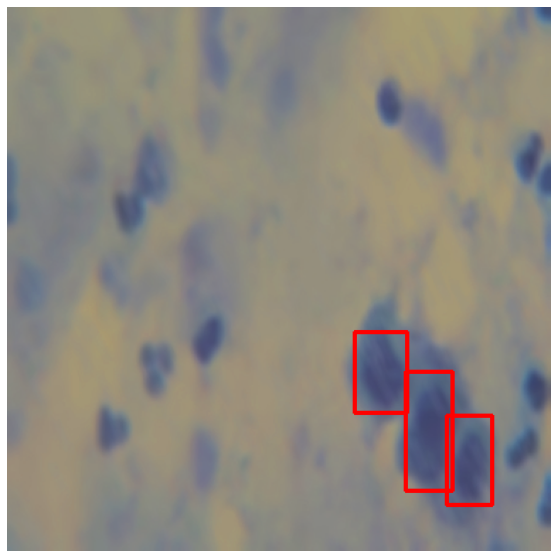

In [39]:
# {1632, 1800, 1960, 4000} w
# {1560, 1800, 4000, 4032} h
# path = list(df1[df1['w'] == 1632]['path'])[0]
path = list(df1[df1['h'] == 4000]['path'])[25]
# path = list(df1[df1['bw'] > 300]['path'])[0]
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape
print(image.shape)
my_df = df1[df1['path'] == path].copy()
my_df.reset_index(inplace=True)
new_bboxes = []
for i in range(len(my_df)) :
    xmin, ymin, xmax, ymax = my_df.loc[i, 'xmin'], my_df.loc[i, 'ymin'], my_df.loc[i, 'xmax'], my_df.loc[i, 'ymax']
    new_bboxes.append([xmin, ymin, xmax, ymax])
transformed = transforms(image=image, bboxes=new_bboxes, labels=[1]*len(new_bboxes))
transformed_image = transformed['image']
print(transformed_image.shape)
# print(type(transformed_image))
# transformed_image = transformed_image.transpose(2,0)
# transformed_image = transformed_image.transpose(1,0)
# transformed_image = torch.transpose(transformed_image, 1, 2, 0)
# print(transformed_image.shape)
transformed_bboxes = transformed['bboxes']
# print(transformed_bboxes)
transformed_class_labels = transformed['labels']
# print(transformed_class_labels)
category_ids = [0] * len(transformed_bboxes)
category_id_to_name = {0: 'Carcinoma', 1: 'normal'}
visualize(transformed_image, transformed_bboxes, category_ids, category_id_to_name)

In [40]:
print(transformed_class_labels)

[1, 1, 1]
